In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import pandas as pd
import os
import shutil  # For copying files from /kaggle/input to /kaggle/working

paths = []
for dirname, _, filenames in os.walk("/kaggle/input/thyroidultrasound/p_image"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

# Split all paths by extension
imgs = []
for path in paths:
    if path.split('.')[-1] == "PNG":
       imgs.append(Image.open(path))
        

In [3]:
import pandas as pd
import os
import shutil  # For copying files from /kaggle/input to /kaggle/working

paths = []
for dirname, _, filenames in os.walk("/kaggle/input/thyroidultrasound/p_mask"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

# Split all paths by extension
masks = []
for path in paths:
    if path.split('.')[-1] == "PNG":
       masks.append(Image.open(path))
        

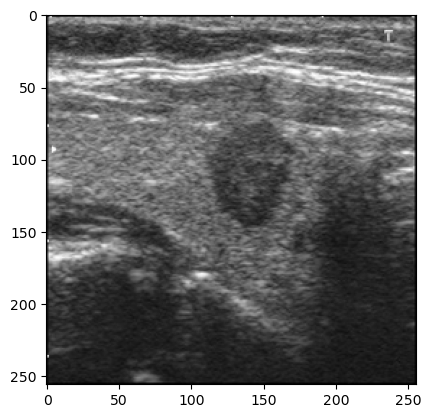

In [4]:
plt.imshow(imgs[10],cmap='gray')

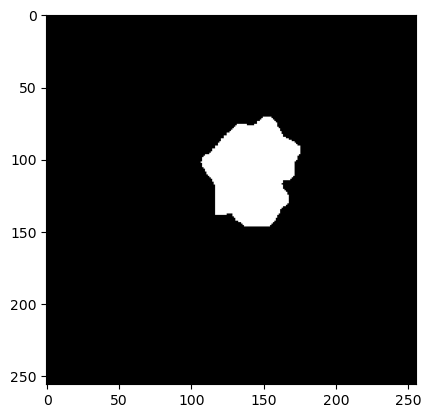

In [5]:
plt.imshow(masks[10],cmap='gray')

In [6]:
len(masks)

637

In [7]:
Images=[]
for x in imgs:
    Images.append(img_to_array(x));
mks=[]
for y in masks:
    mks.append(img_to_array(y));

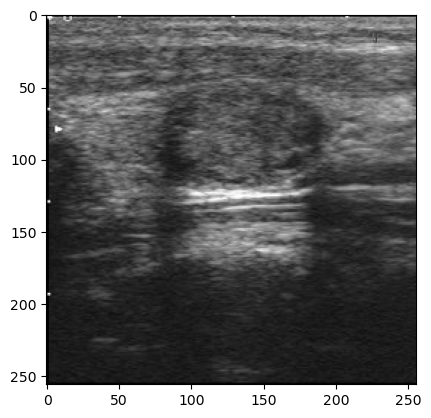

In [8]:
plt.imshow(Images[0],cmap='gray')

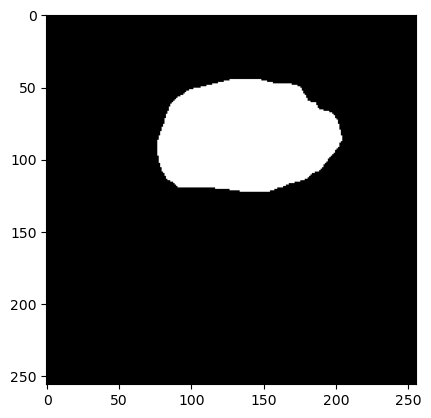

In [9]:
plt.imshow(mks[0],cmap="gray")

In [10]:
def convertToThreeChannel(img):
    b_np= np.array(img)
    g_np= np.array(img)
    r_np= np.array(img)
    final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
    return np.array(final_img)

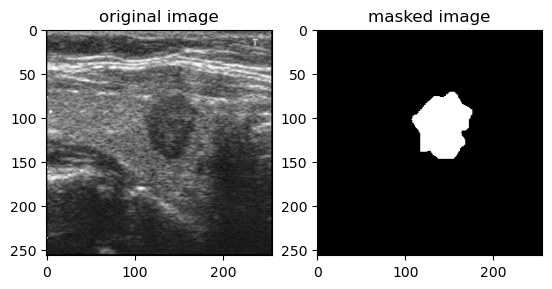

In [11]:
A=[]
for i in Images:
    A.append(convertToThreeChannel(i))
B=[]
for j in mks:
    B.append(convertToThreeChannel(j))
plt.figure
plt.subplot(1,2,1)
plt.imshow(A[10])
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(B[10])
plt.title("masked image")
plt.show()

In [12]:
actual=[]
mask=[]
for i in A:
    horizontal_flip = cv2.flip(i, 1)
    vertical_horizontal_flip = cv2.flip(i, -1)
    imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
    imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
    actual.append(horizontal_flip)
    actual.append(vertical_horizontal_flip)
    actual.append(imagerotate)
    actual.append(imagerotate1)
    actual.append(imagerotate2)

for j in B:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)    

In [13]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3185, 256, 256, 3)
(3185, 256, 256, 3)


In [14]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

1.0
0.0


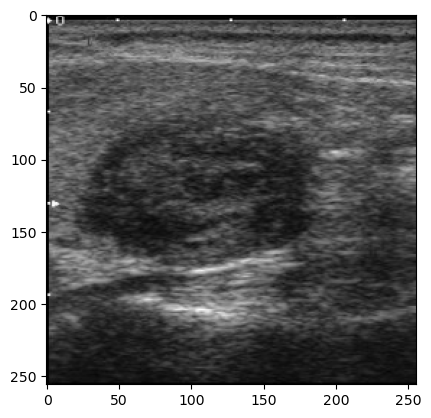

In [15]:
plt.imshow(actual[260])

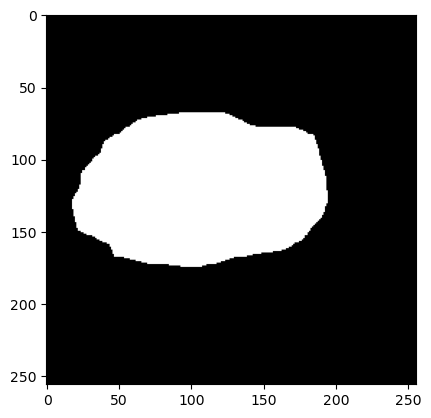

In [16]:
plt.imshow(mask[260])

In [17]:
t1=np.full(2185,1) 
t2=np.full(665,0)
t3=np.full(1050,2)  
T=np.concatenate((t1, t2, t3), axis = 0)
T=np.array(T)

In [18]:
print(T.shape)

(3900,)


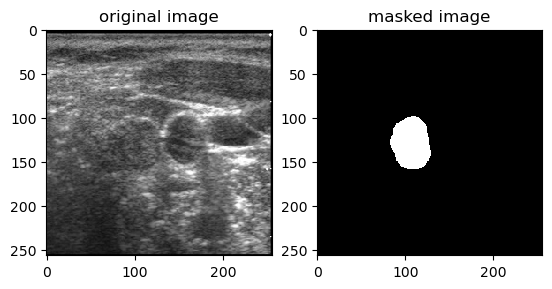

In [19]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[305],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[305],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

In [20]:
X_train=actual[:400];
Y_train=mask[:400];
X_test=actual[400:1050];
Y_test=mask[400:1050];

In [21]:
print(X_train.shape)
print(X_test.shape)

(400, 256, 256, 3)
(650, 256, 256, 3)


In [22]:
inply = Input((256, 256, 3,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [23]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

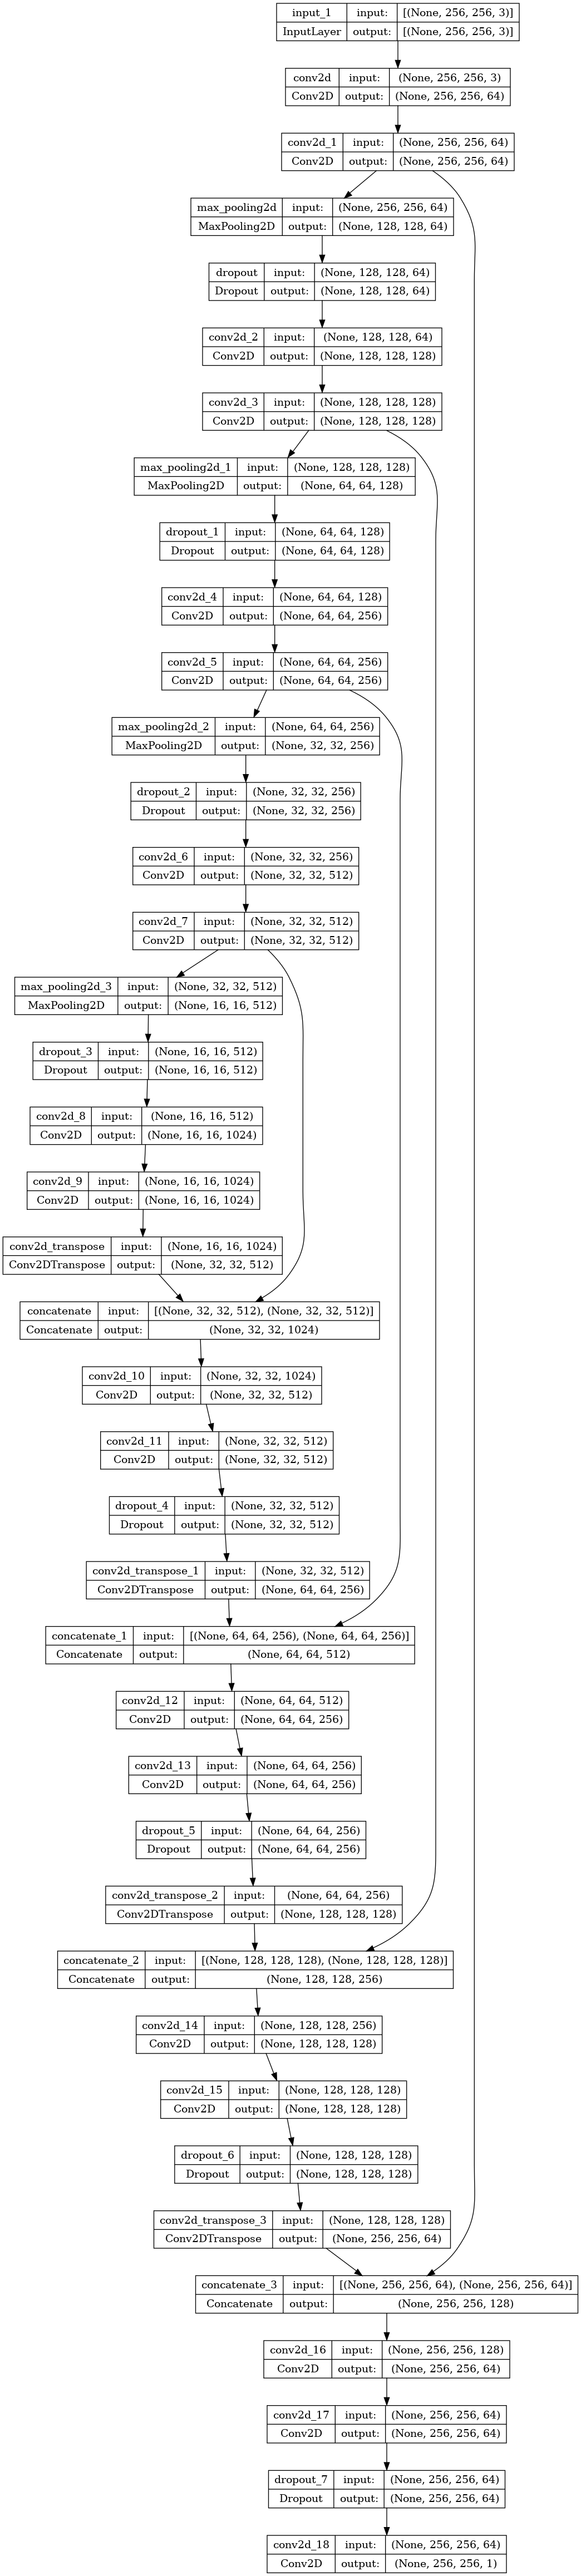

In [24]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [25]:
from keras.metrics import MeanIoU

In [26]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [27]:
from keras.callbacks import ModelCheckpoint

In [28]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

In [29]:
history = model.fit(X_train, Y_train, epochs =13, batch_size = 20, validation_data = (X_test, Y_test), callbacks = [checkp])

Epoch 1/13
20/20 [==============================] - 1993s 101s/step - loss: 0.1451 - acc: 0.8549 - val_loss: 0.1462 - val_acc: 0.8538
Epoch 2/13
20/20 [==============================] - 1961s 100s/step - loss: 0.1451 - acc: 0.8549 - val_loss: 0.1462 - val_acc: 0.8538
Epoch 3/13
20/20 [==============================] - 1972s 100s/step - loss: 0.1451 - acc: 0.8549 - val_loss: 0.1462 - val_acc: 0.8538
Epoch 4/13
20/20 [==============================] - 2082s 106s/step - loss: 0.1451 - acc: 0.8549 - val_loss: 0.1462 - val_acc: 0.8538
Epoch 5/13
20/20 [==============================] - 2117s 107s/step - loss: 0.1451 - acc: 0.8549 - val_loss: 0.1462 - val_acc: 0.8538
Epoch 6/13
20/20 [==============================] - 2137s 109s/step - loss: 0.1451 - acc: 0.8549 - val_loss: 0.1462 - val_acc: 0.8538
Epoch 7/13
20/20 [==============================] - 2130s 108s/step - loss: 0.1451 - acc: 0.8549 - val_loss: 0.1462 - val_acc: 0.8538
Epoch 8/13
20/20 [==============================] - 2072s 105s

In [30]:
import pickle

In [31]:
Pkl_Filename = "Thyroid_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [32]:
from IPython.display import FileLink
FileLink(r'Thyroid_Model.pkl')

/kaggle/working/Thyroid_Model.pkl

In [33]:
print(history)

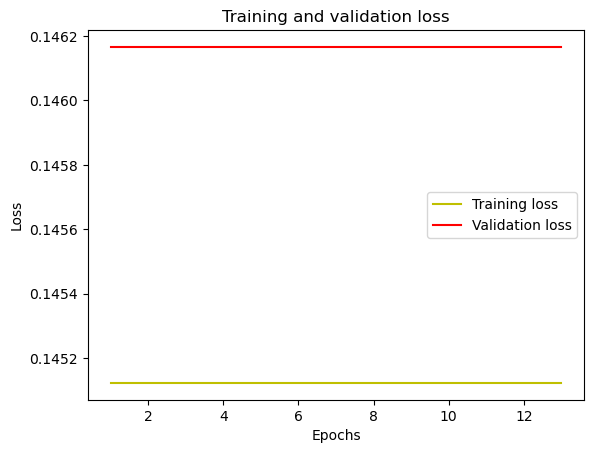

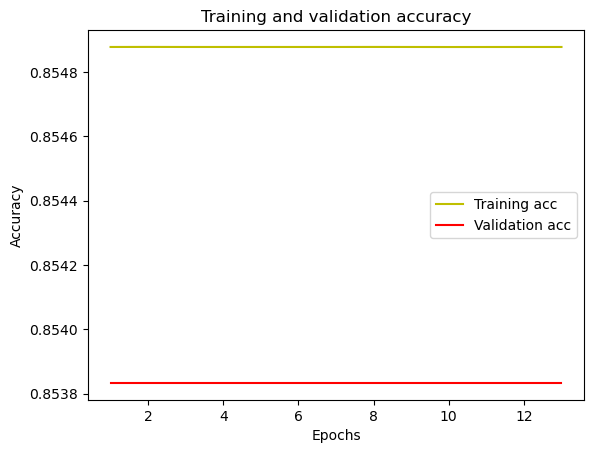

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
y_pred=model.predict(X_test)
y_pred_threshold=y_pred>0.5

21/21 [==============================] - 611s 29s/step


In [36]:
print(np.mean(history.history['val_acc']))

0.8538337349891663


**ACCURACY -: 85.4 %**

In [37]:
import random

(1, 256, 256, 3)
1/1 [==============================] - 1s 920ms/step
(256, 256)


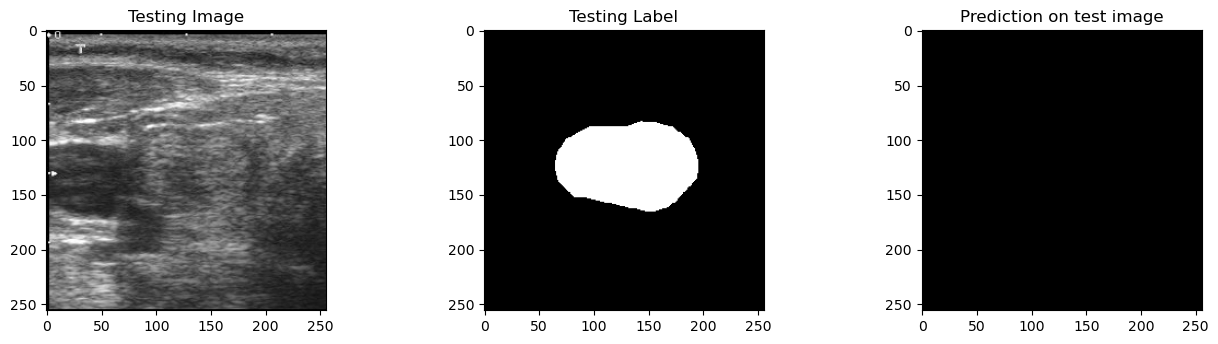

In [38]:
threshold = 0.5
test_img_number = 80
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()